In [13]:
!pip install matplotlib seaborn


You should consider upgrading via the 'C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


[80.0 min] Starting BATCH at Diffusion_FE_125 with 5 lots
[80.0 min] BATCH triggers SETUP at Diffusion_FE_125
[500.0 min] Diffusion_FE_125 starting SCHEDULED PM
[500.0 min] WE_FE_84 starting SCHEDULED PM
[500.0 min] DefMEt_FE_118 starting SCHEDULED PM
[500.0 min] TF_Met_FE_45 starting SCHEDULED PM
[500.0 min] Diffusion_FE_127 starting SCHEDULED PM
[500.0 min] WE_FE_108 starting SCHEDULED PM
[500.0 min] WE_FE_83 starting SCHEDULED PM
[500.0 min] LithoTrack_FE_115 starting SCHEDULED PM
[500.0 min] Litho_FE_92 starting SCHEDULED PM
[500.0 min] LithoMet_FE_19 starting SCHEDULED PM
[500.0 min] Litho_REG_FE_64 starting SCHEDULED PM
[500.0 min] DefMet_FE_10 starting SCHEDULED PM
[500.0 min] Implant_128 starting SCHEDULED PM
[500.0 min] DE_FE_1 starting SCHEDULED PM
[500.0 min] DE_FE_86 starting SCHEDULED PM
[500.0 min] DefMet_FE_43 starting SCHEDULED PM
[500.0 min] Diffusion_FE_44 starting SCHEDULED PM
[500.0 min] DE_FE_51 starting SCHEDULED PM
[500.0 min] LithoTrack_FE_95 starting SCHEDULED 

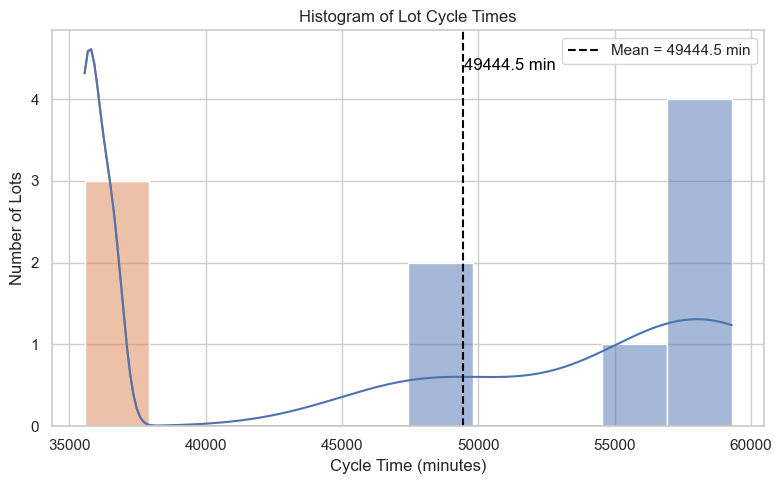

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7988\1553052703.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x='Priority', y='CycleTime', palette='Set2')


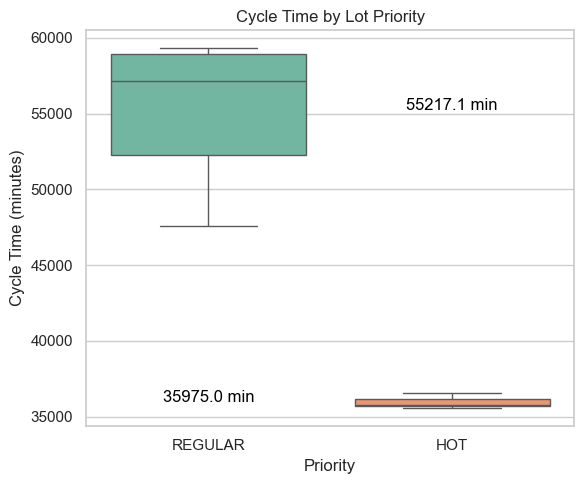

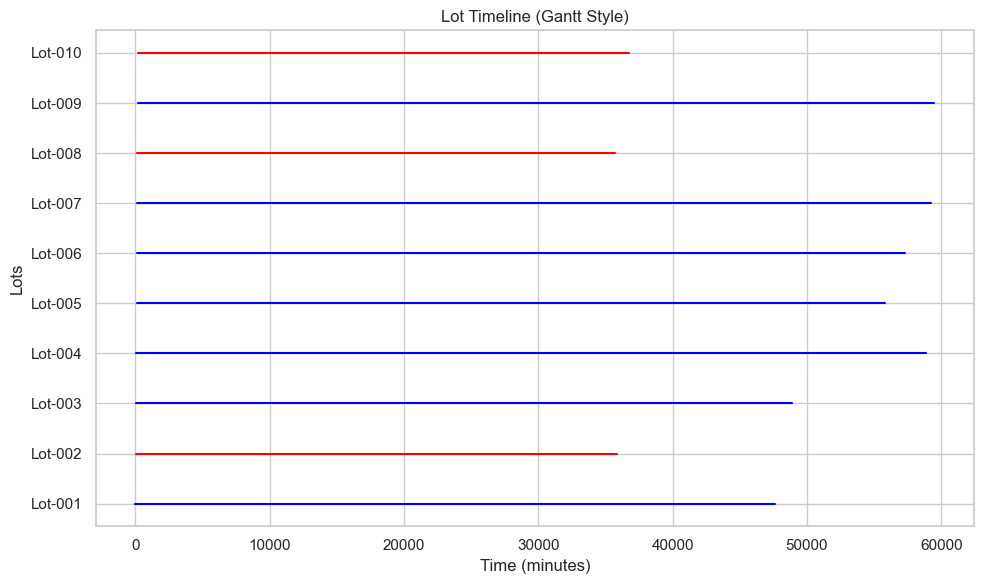

In [15]:
import simpy
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: use nicer styles
sns.set(style="whitegrid")

# ----------------------------
# Load Route Data (Product 1)
# ----------------------------
file_path = "SMT_2020_Model_Data_-_LVHM.xlsx"
route_df = pd.read_excel(file_path, sheet_name='Route_Product_1')
steps = route_df[['STEP', 'TOOLGROUP', 'MEAN', 'PROCESSING UNIT']].dropna()
steps['MEAN'] = pd.to_numeric(steps['MEAN'], errors='coerce')

# ----------------------------
# Simulation Parameters
# ----------------------------
NUM_LOTS = 10
INTER_ARRIVAL_TIME = 20     # min between lots
SETUP_TIME = 5              # min
PM_INTERVAL = 500           # scheduled downtime every X min
PM_DURATION = 30            # fixed PM length
MTBF = 800                  # mean time between failures
MTTR = 60                   # mean time to repair
SIM_TIME = 100000            # max simulation time (minutes)

# Batch parameters
BATCH_SIZE = 6
MIN_BATCH = 5
batch_tools = ['Diffusion_FE_125']  # Add more if needed

# Track lot cycle times
lot_times = {}

# ----------------------------
# Setup SimPy Environment
# ----------------------------
env = simpy.Environment()
tool_resources = {}
tool_available = {}
last_operation = {}
batch_queues = {}

# Initialize tool resources and trackers
for tool in steps['TOOLGROUP'].unique():
    tool_resources[tool] = simpy.PriorityResource(env, capacity=1)
    tool_available[tool] = True
    last_operation[tool] = None
    if tool in batch_tools:
        batch_queues[tool] = []

# ----------------------------
# Tool Downtime Behavior
# ----------------------------
def tool_downtime_behavior(env, tool_name):
    while True:
        # Scheduled PM
        yield env.timeout(PM_INTERVAL)
        print(f"[{env.now:.1f} min] {tool_name} starting SCHEDULED PM")
        tool_available[tool_name] = False
        yield env.timeout(PM_DURATION)
        tool_available[tool_name] = True
        print(f"[{env.now:.1f} min] {tool_name} completed PM")

        # Random breakdown
        uptime = random.expovariate(1.0 / MTBF)
        yield env.timeout(uptime)
        print(f"[{env.now:.1f} min] {tool_name} BREAKDOWN occurred")
        tool_available[tool_name] = False
        yield env.timeout(random.expovariate(1.0 / MTTR))
        tool_available[tool_name] = True
        print(f"[{env.now:.1f} min] {tool_name} repaired from BREAKDOWN")

for tool in tool_resources:
    env.process(tool_downtime_behavior(env, tool))

# ----------------------------
# Lot Processing Function
# ----------------------------
def process_lot_through_route(env, steps, lot_id, priority_label, priority_level):
    lot_times[lot_id] = {'start': env.now, 'end': None, 'priority': priority_label}

    for _, row in steps.iterrows():
        tool_name = row['TOOLGROUP']
        proc_time = row['MEAN']
        step_id = row['STEP']

        # Wait if tool is down
        while not tool_available[tool_name]:
            print(f"[{env.now:.1f} min] {lot_id} ({priority_label}) waiting: {tool_name} is DOWN")
            yield env.timeout(5)

        # ----------- BATCH TOOLS -----------
        if tool_name in batch_tools:
            queue = batch_queues[tool_name]
            batch_event = env.event()
            lot_info = (lot_id, priority_label, priority_level, batch_event, step_id)

            queue.append(lot_info)

            if len(queue) >= MIN_BATCH:
                batch = queue[:BATCH_SIZE]
                batch_queues[tool_name] = queue[BATCH_SIZE:]

                with tool_resources[tool_name].request(priority=0) as request:
                    yield request

                    print(f"[{env.now:.1f} min] Starting BATCH at {tool_name} with {len(batch)} lots")

                    if last_operation[tool_name] != step_id:
                        print(f"[{env.now:.1f} min] BATCH triggers SETUP at {tool_name}")
                        yield env.timeout(SETUP_TIME)
                        last_operation[tool_name] = step_id

                    yield env.timeout(proc_time)

                    for (bid, blabel, _, bevent, _) in batch:
                        if not bevent.triggered:
                            print(f"[{env.now:.1f} min] {bid} ({blabel}) ends at {tool_name}")
                            bevent.succeed()

            yield batch_event  # wait for this lot's batch to complete

        # ----------- NON-BATCH TOOLS -----------
        else:
            with tool_resources[tool_name].request(priority=priority_level) as request:
                yield request

                if last_operation[tool_name] != step_id:
                    print(f"[{env.now:.1f} min] {lot_id} ({priority_label}) triggers SETUP at {tool_name}")
                    yield env.timeout(SETUP_TIME)
                    last_operation[tool_name] = step_id

                print(f"[{env.now:.1f} min] {lot_id} ({priority_label}) starts at {tool_name}")
                yield env.timeout(proc_time)
                print(f"[{env.now:.1f} min] {lot_id} ({priority_label}) ends at {tool_name}")

    # After final step
    lot_times[lot_id]['end'] = env.now

# ----------------------------
# Lot Generator
# ----------------------------
def lot_generator(env):
    for i in range(NUM_LOTS):
        lot_id = f"Lot-{i+1:03d}"
        is_hot = random.random() < 0.2
        priority_label = "HOT" if is_hot else "REGULAR"
        priority_level = 0 if is_hot else 1

        env.process(process_lot_through_route(env, steps, lot_id, priority_label, priority_level))
        yield env.timeout(INTER_ARRIVAL_TIME)

# ----------------------------
# Run Simulation
# ----------------------------
random.seed(42)
env.process(lot_generator(env))
env.run(until=SIM_TIME)

# ----------------------------
# Post-Simulation: Cycle Time Report
# ----------------------------
print("\n📊 LOT CYCLE TIME SUMMARY")
results = []

for lot_id, times in lot_times.items():
    start = times['start']
    end = times['end']
    priority = times['priority']
    if end is not None:
        cycle_time = end - start
        results.append((lot_id, priority, start, end, cycle_time))
        print(f"{lot_id:10} | {priority:8} | Start: {start:6.1f} | End: {end:6.1f} | Cycle: {cycle_time:6.1f} min")
    else:
        print(f"{lot_id:10} | {priority:8} | Incomplete (didn't finish in {SIM_TIME} min)")

# Optional: store results in DataFrame
df_results = pd.DataFrame(results, columns=['Lot', 'Priority', 'Start', 'End', 'CycleTime'])

# Summary Stats
print("\n🔍 Cycle Time Stats:")
print(df_results.groupby('Priority')['CycleTime'].describe())

# Histogram of cycle times
plt.figure(figsize=(8, 5))
sns.histplot(data=df_results, x='CycleTime', bins=10, kde=True, hue='Priority', multiple='stack')
mean_cycle = df_results['CycleTime'].mean()
plt.axvline(mean_cycle, color='black', linestyle='--', label=f'Mean = {mean_cycle:.1f} min')
plt.text(mean_cycle + 20, plt.gca().get_ylim()[1]*0.9, f'{mean_cycle:.1f} min', color='black')
plt.title("Histogram of Lot Cycle Times")
plt.xlabel("Cycle Time (minutes)")
plt.ylabel("Number of Lots")
plt.legend()
plt.tight_layout()
plt.show()


# Boxplot grouped by HOT/REGULAR
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_results, x='Priority', y='CycleTime', palette='Set2')

# Annotate mean per group
group_means = df_results.groupby('Priority')['CycleTime'].mean()
for i, (priority, mean) in enumerate(group_means.items()):
    plt.text(i, mean + 10, f'{mean:.1f} min', color='black', ha='center')

plt.title("Cycle Time by Lot Priority")
plt.ylabel("Cycle Time (minutes)")
plt.tight_layout()
plt.show()


# Timeline plot
plt.figure(figsize=(10, 6))
for i, row in df_results.iterrows():
    plt.plot([row['Start'], row['End']], [i, i], label=row['Lot'], color='red' if row['Priority'] == 'HOT' else 'blue')
plt.xlabel("Time (minutes)")
plt.ylabel("Lots")
plt.title("Lot Timeline (Gantt Style)")
plt.yticks(range(len(df_results)), df_results['Lot'])
plt.tight_layout()
plt.show()

